# A comparison of hospital SHAP values and SHAP main effect values for the 10k cohort.

## Plain English summary

In response to stroke teams being told that they are performing differently from other, they often state that this is due to them having a different set of patients.

This does have some truth to it. For example the hospitals in London will have younger patients, arriving sooner than compared to hospitals in more rural locations.

In order to remove patient differences from results, a common 10k cohort of patients will be used with each of the hospital models. That way any difference is due to hospital factors, and not patient factors.

We've previously seen that the predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45% across the 132 hospitals, and that the size of the hospital only accounted for 10% of the variation in thrombolysis use, and so there are other factors that account for the remaining 90%.

In this notebook we will calculate the SHAP value and the SHAP main effect for the one hot encoded hospital features for the 10k cohort dataset, and compare the values with the the hospitals thrombolysis rate.

We found that the 10k thrombolysis rate correlates closely with average hospital SHAP value (and SHAP main effect).

## Model and data

We use an XGBoost model that was trained on all but a 10k patient cohort, to predict which patient will recieve thrombolysis.

The XGBoost model is fitted to all but 10k instances, and uses 10 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims:

* Use an XGBoost model that was trained on all data except for a 10k set of patients
* Calculate the SHAP value and SHAP main effect
* Analyse the range of SHAP values and SHAP main effect values for the one-hot encoded hospital features (show as two populations: the attended hospital, the sum of the hospitals not attended)
* Compare SHAP value and SHAP main effect with hosptial thrombolysis rates.

## Observations
* SHAP values have a wider range of values for the attended hospital (-2.3 to 2.5), than the unattended hospital (-0.3 to 0.2).
* SHAP main effect values have the same pattern, but a smaller range for each (attended hospital: -1.5 to 1.5, unattended hospital: -0.1 to 0.02).
* Nearly 95% of the variability in 10k hospital thrombolysis rate can be explained by the average hospital SHAP value.
* 97% of the variability in 10k hospital thrombolysis rate can be explained by the average hospital SHAP main effect value.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap
import copy

from scipy import stats

import pickle

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier

from os.path import exists
import json

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_key_features = 10
model_text = f'xgb_{number_key_features}_features_10k_cohort'
notebook = '04a'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [5]:
data_loc = '../data/10k_training_test/'

In [6]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_key_features]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=dict_feature_name, inplace=True)
test = test[key_features]
test.rename(columns=dict_feature_name, inplace=True)

#### Get list of hospital names

In [7]:
hospitals = list(set(train['Stroke team']))
hospitals.sort()

### Divide data into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict). By convention our features are called X (usually upper case to denote multiple features), and the label (thrombolysis or not) y.

In [8]:
# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

### One-hot encode hospital feature

In [9]:
# One hot encode hospitals (training set)
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)

# One hot encode hospitals (test set)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)    

## Load XGBoost model

Load XGBoost model that's trained on the 10k cohort train/test dataset (from notebook 04)

In [10]:
filename = (f'./saved_models/04_{model_text}.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)

## SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values
TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Once set up, we can use this explainer to calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

Setup method to estimate SHAP values (in their default units: log odds)

In [11]:
# Set up method to estimate SHAP values for tree models and ensembles of trees
filename = (f'./output/{notebook}_{model_text}_shap_explainer.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP explainer
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Get SHAP explainer (using the model and feature values from training set)
    explainer = shap.TreeExplainer(model, X_train)
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

In [12]:
# Repeat for SHAP explainer with probabilities
filename = (f'./output/{notebook}_{model_text}_shap_explainer_probability.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP explainer
    with open(filename, 'rb') as filehandler:
        explainer_probability = pickle.load(filehandler)
else:
    # Get SHAP explainer (using the model and feature values from training set)
    # This is not used in this notebook but is saved for other notebooks to use
    explainer_probability = shap.TreeExplainer(model, X_train, 
                                               model_output='probability')
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer_probability, filehandler)

Initialise dictionaries to store shap_values_extended per hospital

In [13]:
# Initialise dictionary to store shap_values per hospital.
dict_shap_values_extended = {}

# Get SHAP values
filename = (f'./output/{notebook}_{model_text}_dict_shap_values_extended.p')
file_exists = exists(filename)

if file_exists:
    # Load SHAP values (in a dictionary, using hospital as a key
    with open(filename, 'rb') as filehandler:
        dict_shap_values_extended = pickle.load(filehandler)
else:
    # For each hospital calculate SHAP values for the test set (all 10k cohort
    #   going to each hospital)
    count = 0

    # Loop through the hospitals
    for hospital in hospitals:
        # Print progress
        count += 1
        print (f"Calculating SHAP for hospital {count} of {len(hospitals)}")
        
        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital feature values, set all hosptial IDs to zero, set
        #   selected hospital to 1
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        # Join updated hospital feature values to rest of test set
        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get SHAP values (along with base and feature values)
        shap_values_extended = explainer(X_test_adjusted)
        
        # Add to overall shap_values_extended
        dict_shap_values_extended[f"{hospital}"] = shap_values_extended
        
    # Save the dictionary containing the shap values extended
    with open(filename, 'wb') as filehandler:
        pickle.dump(dict_shap_values_extended, filehandler)

#### Format the SHAP values data

Features are in the same order in shap_values as they are in the original dataset.

Use this fact to extract the SHAP values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns:
* contribution from all the hospital features
* contribution from attending the hospital
* contribution from not attending the rest

In [14]:
filename = f'./output/{notebook}_{model_text}_SHAP_values.csv'
file_exists = exists(filename)

if file_exists:
    df_hosp_shap_values = pd.read_csv(filename)
else:
    # Get list of hospital one hot encoded column titles
    hospitals_ohe = X_test.filter(regex='^team',axis=1).columns
    n_hospitals = len(hospitals_ohe)

    # Create list of column index for these hospital column titles
    hospital_columns_index = (
        [X_test.columns.get_loc(col) for col in hospitals_ohe])

    # Create column titles
    columns = copy.deepcopy(hospitals)
    columns.append("Stroke team")
    columns.append("All stroke teams")
    columns.append("Attended stroke team")
    columns.append("Not attended stroke teams")

    # Initialise empty dataframe with these titles
    df_hosp_shap_values = pd.DataFrame(columns=columns)

    # For each hospital
    for hospital in hospitals:
        # Get hospital SHAP values extended
        shap_values_extended = dict_shap_values_extended[f"{hospital}"]

        # Use the index list to access the hosptial shap values (as array)
        hosp_shap_values = shap_values_extended.values[:,hospital_columns_index]
        
        # Put in dataframe with hospital as column title
        df_temp = pd.DataFrame(hosp_shap_values, columns = hospitals)

        # Store the sum of the SHAP values (for all of the hospital features)
        df_temp["All stroke teams"] = df_temp.sum(axis=1)

        # Store which hospital patient went to
        df_temp["Stroke team"] = hospital

        # Store the SHAP values for the hospital attended
        df_temp["Attended stroke team"] = df_temp[f"{hospital}"]

        # Store the sum of the SHAP values for all of the hospitals not attended
        df_temp["Not attended stroke teams"] = (df_temp["All stroke teams"] - 
                                                df_temp["Attended stroke team"])

        # Add to master DataFrame
        df_hosp_shap_values = pd.concat([df_hosp_shap_values, df_temp], axis=0)

# View preview
df_hosp_shap_values.head()

,AGNOF1041H,AKCGO9726K,AOBTM3098N,APXEE8191H,ATDID5461S,BBXPQ0212O,BICAW1125K,BQZGT7491V,BXXZS5063A,CNBGF2713O,...,YEXCH8391J,YPKYH1768F,YQMZV4284N,ZBVSO0975W,ZHCLE1578P,ZRRCV7012C,Stroke team,All stroke teams,Attended stroke team,Not attended stroke teams
0,0.346294,-0.003586,0.0,0.0,0.0,0.0,0.0,-0.008723,0.0,0.0,...,0.0,0.0,-0.006462,0.009641,0.0,0.0,AGNOF1041H,0.328467,0.346294,-0.017827
1,0.020056,-0.022589,0.0,0.0,0.0,0.0,0.0,-0.007895,0.0,0.0,...,0.0,0.0,-0.002869,0.009464,0.0,0.0,AGNOF1041H,-0.08161,0.020056,-0.101666
2,-0.154946,-0.005871,0.0,0.0,0.0,0.0,0.0,-0.001841,0.0,0.0,...,0.0,0.0,-0.00335,0.009117,0.0,0.0,AGNOF1041H,-0.266755,-0.154946,-0.111809
3,0.159131,-0.01069,0.0,0.0,0.0,0.0,0.0,-0.016698,0.0,0.0,...,0.0,0.0,-0.003343,0.009693,0.0,0.0,AGNOF1041H,0.125183,0.159131,-0.033947
4,-0.115854,-0.012736,0.0,-0.002466,0.0,0.0,0.0,-0.0078,0.0,0.0,...,0.0,0.0,-0.002686,0.004752,0.0,0.0,AGNOF1041H,-0.221535,-0.115854,-0.105681


What's the overall range of SHAP values for the hosptials attended and not attended?

In [15]:
print(f"The range of SHAP values for the attended hospitals are "
      f"{round(df_hosp_shap_values['Attended stroke team'].min(), 2)} to "
      f"{round(df_hosp_shap_values['Attended stroke team'].max(), 2)}")
print(f"The range of SHAP values for the not attended hospitals are "
      f"{round(df_hosp_shap_values['Not attended stroke teams'].min(), 2)} to "
      f"{round(df_hosp_shap_values['Not attended stroke teams'].max(), 2)}")

The range of SHAP values for the attended hospitals are -2.3 to 2.53
The range of SHAP values for the not attended hospitals are -0.27 to 0.15


### Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature)

A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect), for each instance. The SHAP value for a feature is the sum of it's pair-wise feature interactions.

Use these values to access the main effect for each of the one-hot encoded hospital features.

Either load from pickle (if file exists), or calculate.

#### At the same tiume: Format the SHAP interaction data so only get the main effect for the hospital features

Features are in the same order in shap_interaction as they are in the original dataset.

Use this fact to extract the SHAP main effect values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

Also include a column containing the Stroke team that each instance attended.

And three further columns:
1. contribution from all the hospital features
2. contribution from attending the hospital
3. contribution from not attending the rest

SHAP interaction values have a matrix of values (per pair of features) per instance.

For each hospital, have the 10k instances each with a 139x139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

Once get the SHAP interaction values, get the main effects for just the hospital features and store these in a row in a dataframe. So the dataframe has a row per instance and a hospital per column with each value being the main effect for that feature.

In [16]:
filename = f'./output/{notebook}_{model_text}_shap_main_effects_df.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction array
    with open(filename, 'rb') as filehandler:
        df_hosp_shap_main_effects = pickle.load(filehandler)
else:
    # Get list of hospital one hot encoded column titles
    hospitals_ohe = X_test.filter(regex='^team',axis=1).columns
    n_hospitals = len(hospitals_ohe)

    # Create list of column index for these hospital column titles
    hospital_columns_index = [
                        X_test.columns.get_loc(col) for col in hospitals_ohe]

    # SHAP explainer model
    explainer = shap.TreeExplainer(model)

    # Set up counter
    count = 0

    # For each hospital calculate SHAP values for the test set (all going to 
    #   each hospital)
    for hospital in hospitals:
        # Print progress
        count += 1
        print (f"Calculating SHAP main effect for hospital {count} of "
               f"{len(hospitals)}")

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital feature values, set all hosptial IDs to zero, set
        #   selected hospital to 1
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        # Join updated hospital feature values to rest of test set
        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get SHAP interactions
        hosp_shap_interaction = (
                            explainer.shap_interaction_values(X_test_adjusted))
                
        # Initialise list
        hosp_shap_main_effects = []
        
        # For each patient
        for i in range(hosp_shap_interaction.shape[0]):
        # Get the main effect value for each of the hospital features
            main_effects = np.diagonal(hosp_shap_interaction[i])
            hosp_shap_main_effects.append(main_effects[hospital_columns_index])
        
        # Put in dataframe with hospital as column title
        df_temp = pd.DataFrame(hosp_shap_main_effects, columns=hospitals)

        # Store the sum of the SHAP values (for all of the hospital features)
        df_temp["All stroke teams"] = (df_temp.sum(axis=1))

        # Include Stroke team that each instance attended
        df_temp["Stroke team"] = hospital

        # Store the SHAP values for the hospital attended
        df_temp["Attended stroke team"] = df_temp[f"{hospital}"]

        # Store the sum of the SHAP values for all of the hospitals not attended
        df_temp["Not attended stroke teams"] = (
                            df_temp["All stroke teams"] - 
                            df_temp["Attended stroke team"])

        if hospital == hospitals[0]:
            # For first hospital, make the tuple collecting a copy of the first 
            #   hospital, others will be added to this
            df_hosp_shap_main_effects = df_temp.copy(deep=True)
        else:
            # Add to master DataFrame
            df_hosp_shap_main_effects = pd.concat(
                            [df_hosp_shap_main_effects, df_temp], axis=0) 

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(df_hosp_shap_main_effects, filehandler) 

What's the overall range of SHAP main effect values for the hosptials attended and not attended?

In [17]:
print(f"The range of SHAP main effect values for the attended hospitals are "
      f"{round(df_hosp_shap_main_effects['Attended stroke team'].min(),2)} to "
      f"{round(df_hosp_shap_main_effects['Attended stroke team'].max(),2)}")
print(f"The range of SHAP main effect values for the not attended hospitals are "
      f"{round(df_hosp_shap_main_effects['Not attended stroke teams'].min(),2)}"
      f"  to "
      f"{round(df_hosp_shap_main_effects['Not attended stroke teams'].max(),2)}")

The range of SHAP main effect values for the attended hospitals are -1.52 to 1.53
The range of SHAP main effect values for the not attended hospitals are -0.11  to 0.02


## Compare the range of SHAP values and SHAP main effect values for each hospital feature
#### Boxplot (all hospitals together)

Analyse the range of SHAP values and SHAP main effect values for the one-hot encoded hospital features. Show as two populations: the attended hospital, the sum of the hospitals not attended

To create a grouped boxplot, used code from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

Colors are from http://colorbrewer2.org/

In [18]:
def set_box_color(bp, color):
    """
    Colour the boxplot in the plot
    
    bp [boxplot object]: The box to change colour
    color [HEX]: Colour to use for the boxplot 
    """
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['means'], color=color)
    return()

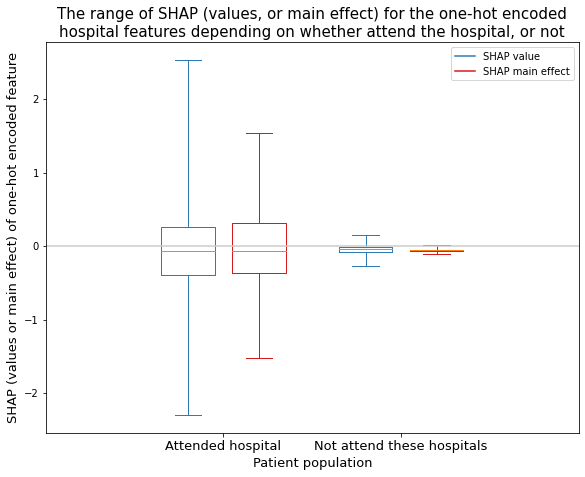

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ticks = ["Attended hospital", "Not attend these hospitals"]

plot_data_sv = [df_hosp_shap_values["Attended stroke team"], 
                df_hosp_shap_values["Not attended stroke teams"]]

bp_sv = plt.boxplot(plot_data_sv, 
                  positions=np.array(range(len(plot_data_sv)))*2.0-0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_sv, '#2C7BB6')

plot_data_me = [df_hosp_shap_main_effects["Attended stroke team"], 
                df_hosp_shap_main_effects["Not attended stroke teams"]]
bp_me = plt.boxplot(plot_data_me, 
                  positions=np.array(range(len(plot_data_me)))*2.0+0.4, 
                  sym='', whis=99999, widths=0.6)
set_box_color(bp_me, '#D7191C')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#2C7BB6', label='SHAP value')
plt.plot([], c='#D7191C', label='SHAP main effect')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks, size=13)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()

# Add line at Shap = 0
ax.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 

title = ("The range of SHAP (values, or main effect) for the one-hot encoded\n"
         "hospital features depending on whether attend the hospital, or not")
plt.title(title, size=15)
plt.ylabel('SHAP (values or main effect) of one-hot encoded feature', size=13)
plt.xlabel('Patient population', size=13)
plt.savefig(f'./output/{notebook}_{model_text}'
            f'_hosp_shap_value_and_maineffect_attend_vs_notattend_boxplot.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Boxplot (individual hospitals)
Create a boxplot to show the range of SHAP values and SHAP main effect values for each individual one-hot encoded hospital feature.

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of mean SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the mean SHAP main effect, and mean SHAP values for each hosptial (for those instances that attended the hospital)

In [20]:
def shap_descriptive_stats(hospital_names, df_hosp_shap, prefix_text):
    """
    For each hospital, extract the SHAP values (or SHAP main effect values) for
    those patients that attend the hospital and calculate the descriptive 
    statistics for those instances that attend the hospital.
    
    hospital_names [list]: List of hospital names
    df_hosp_shap [DataFrame]: DataFrame containing hospital SHAP values (or 
                        hospital main effect values).
    prefix_text [string]: add to the column headings (for example, 
                        sv = shap values, me = shap main effect).
    return [DataFrame]: DataFrame with six columns (the hospital, and five 
                        descriptive statistics) containing values for the 
                        attended hospital.
    
    """
    attend_stroketeam_min = []
    attend_stroketeam_q1 = []
    attend_stroketeam_mean = []
    attend_stroketeam_q3 = []
    attend_stroketeam_max = []
    
    # Loop through each hospital
    for h in hospital_names:
        # Create a mask to identify patients attending this hospital
        mask = df_hosp_shap['Stroke team'] == h
        # Extract values for the patients that attend this hospital
        data_stroke_team = df_hosp_shap[h][mask]
        # Calculate descriptive stats (min, interquartile, max) for values
        q1, q3 = np.percentile(data_stroke_team, [25,75])
        attend_stroketeam_min.append(data_stroke_team.min())
        attend_stroketeam_q1.append(q1)
        attend_stroketeam_mean.append(data_stroke_team.mean())
        attend_stroketeam_q3.append(q3)
        attend_stroketeam_max.append(data_stroke_team.max())

    # Create dataframe with six columns (hospital and five descriptive stats)
    df = pd.DataFrame(hospital_names, columns=[f"hospital_{prefix_text}"])
    df[f"shap_min_{prefix_text}"] = attend_stroketeam_min
    df[f"shap_q1_{prefix_text}"] = attend_stroketeam_q1
    df[f"shap_mean_{prefix_text}"] = attend_stroketeam_mean
    df[f"shap_q3_{prefix_text}"] = attend_stroketeam_q3
    df[f"shap_max_{prefix_text}"] = attend_stroketeam_max
    
    return(df)

In [21]:
df_me = shap_descriptive_stats(hospitals, df_hosp_shap_main_effects, "me")
df_sv = shap_descriptive_stats(hospitals, df_hosp_shap_values, "sv")

df_hosp_shap_descriptive_stats = df_me.join(df_sv)
df_hosp_shap_descriptive_stats.drop(columns=["hospital_sv"], inplace=True)
df_hosp_shap_descriptive_stats.rename(columns={"hospital_me": "hospital"}, 
                                      inplace=True)

Sort in descending SHAP main effect value order

In [22]:
df_hosp_shap_descriptive_stats.sort_values("shap_mean_me", 
                                           ascending=False, inplace=True)                
df_hosp_shap_descriptive_stats.head(5)

,hospital,shap_min_me,shap_q1_me,shap_mean_me,shap_q3_me,shap_max_me,shap_min_sv,shap_q1_sv,shap_mean_sv,shap_q3_sv,shap_max_sv
9,CNBGF2713O,0.958873,1.212353,1.269933,1.329043,1.532164,-0.115890,0.706332,1.029775,1.341116,2.194533
109,VKKDD9172T,0.757424,1.046197,1.115861,1.185386,1.464610,0.161343,0.998213,1.321657,1.689903,2.527115
25,GKONI0110I,0.657628,0.967990,1.015090,1.059107,1.339179,-0.111562,0.652781,0.869633,1.094527,1.794004
32,HPWIF9956L,0.656201,0.931542,1.009449,1.076609,1.324047,0.014943,0.749513,1.104536,1.445199,2.115388
65,NTPQZ0829K,0.583794,0.877956,0.918473,0.956586,1.169348,-0.136511,0.662457,0.871900,1.114202,1.600292


Read DataFrame containing thrombolysis rate per hospital for this 10k patient cohort (include this information in the x label).

In [23]:
# Dataframe of hospital thrombolysis rate for the 10k patient cohort
thrombolysis_by_hosp = pd.read_csv(
    f'./output/04_{model_text}_thrombolysis_rate_by_hosp.csv')

thrombolysis_by_hosp = thrombolysis_by_hosp.set_index('stroke_team')
thrombolysis_by_hosp

,Thrombolysis rate
stroke_team,
VKKDD9172T,0.4527
GKONI0110I,0.4132
HPWIF9956L,0.4131
CNBGF2713O,0.4093
TPXYE0168D,0.3962
...,...
LECHF1024T,0.1478
LGNPK4211W,0.1445
OUXUZ1084Q,0.1295


Create data for boxplot

In [24]:
# Go through to order of hospital in
hospital_order = df_hosp_shap_descriptive_stats["hospital"]
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
me_attend_stroketeam_groups_ordered = []
sv_attend_stroketeam_groups_ordered = []    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   do not attend stroke team
me_not_attend_stroketeam_groups_ordered = []
sv_not_attend_stroketeam_groups_ordered = []
# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    me_attend_stroketeam_groups_ordered.append(
                                            df_hosp_shap_main_effects[h][mask])
    mask = df_hosp_shap_values['Stroke team'] == h
    sv_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Not attend
    mask = df_hosp_shap_main_effects['Stroke team'] != h
    me_not_attend_stroketeam_groups_ordered.append(
                                            df_hosp_shap_main_effects[h][mask])
    mask = df_hosp_shap_values['Stroke team'] == h
    sv_not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Label
    thrombolysis_rate = thrombolysis_by_hosp['Thrombolysis rate'].loc[h]
    xlabel.append(f"{h} ({round(thrombolysis_rate * 100, 0)}%)")

Resource for using overall y min and max of both datasets on the 4 plots so have the same range https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.

Shows the range of contributions to the prediction from this hospital when patients attend this hosptial


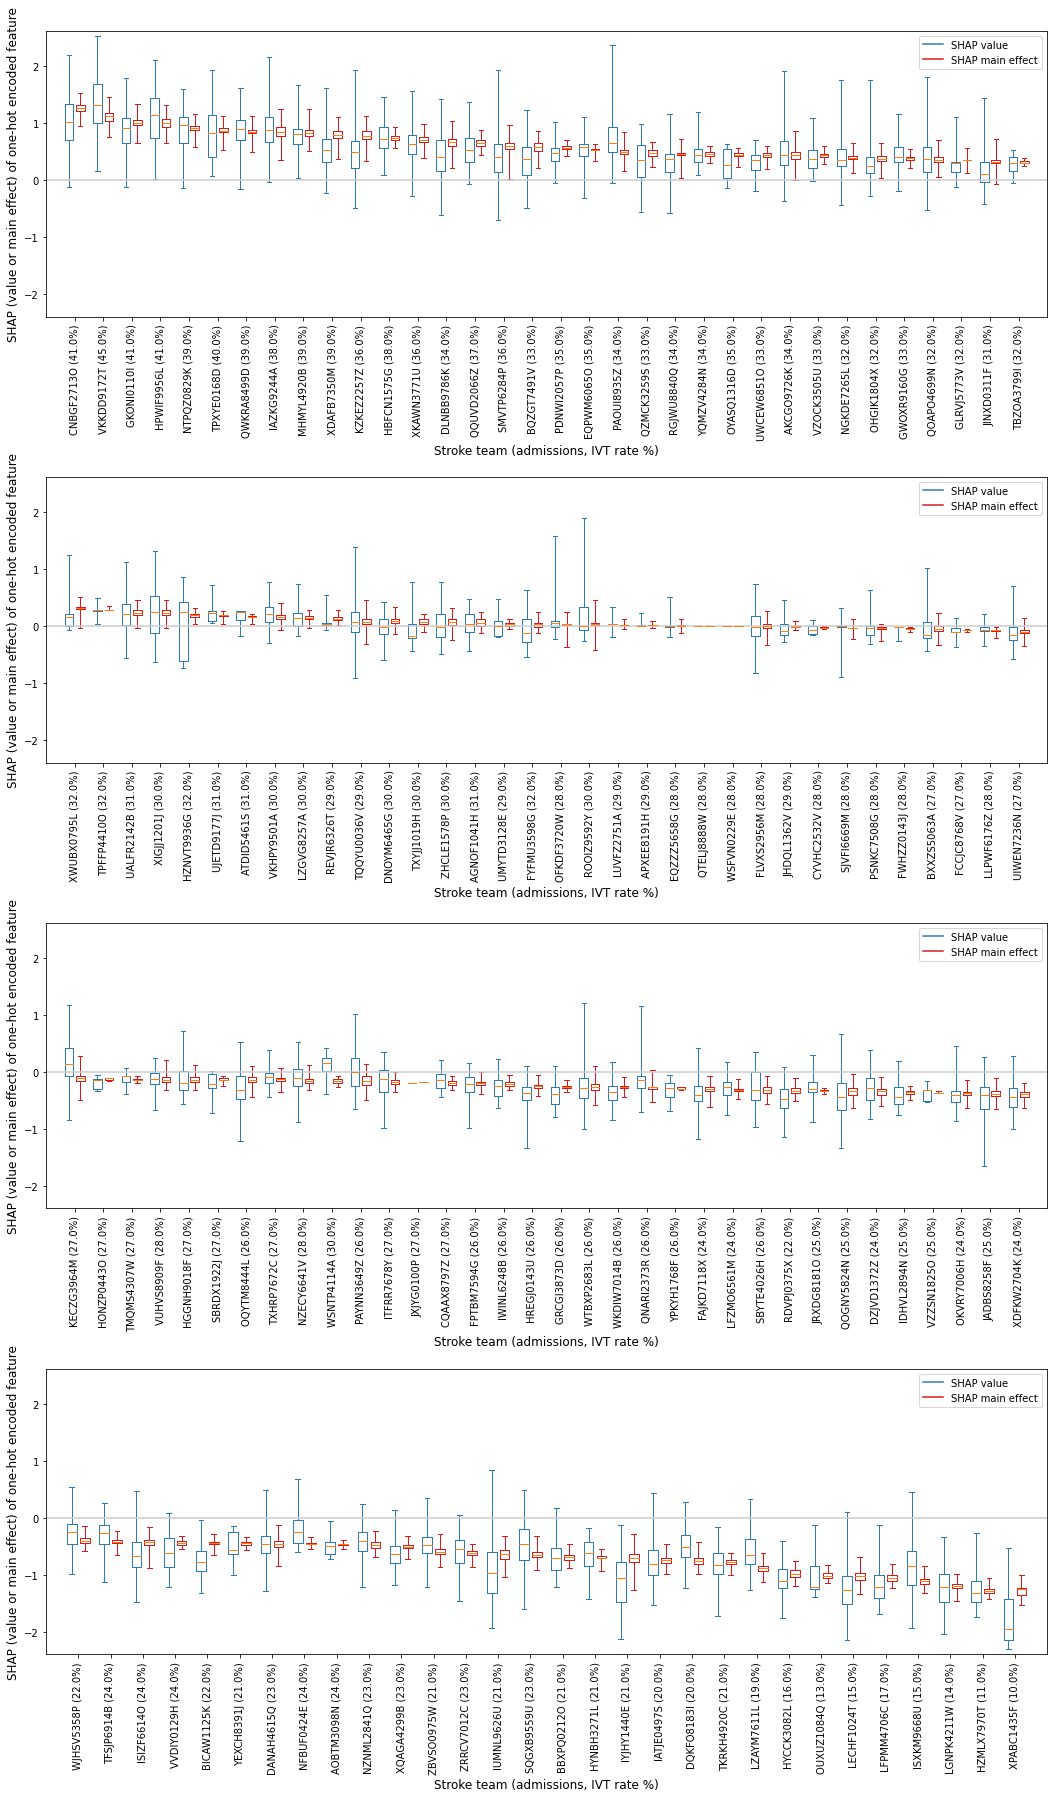

In [25]:
# Plot 34 hospitals on each figure to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients attend this hosptial")

# To group the hospitals into 34
st = 0
ed = 34
inc = ed
max_size = len(hospitals)

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin = min(min(sv_attend_stroketeam_groups_ordered, key=min))
ymax = max(max(sv_attend_stroketeam_groups_ordered, key=max))

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure with 4 subplots
fig = plt.figure(figsize=(15,25))

# Create four subplots
for subplot in range(4):
    ax = fig.add_subplot(4,1,subplot+1)
    
    # "The contribution from this hospital when patients do not attend this 
    #   hosptial"
    ticks = xlabel[st:ed]
    
    pos_sv = np.array(range(
                    len(sv_attend_stroketeam_groups_ordered[st:ed])))*2.0-0.4
    bp_sv = plt.boxplot(sv_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_sv, sym='', whis=99999, widths=0.6)
    
    pos_me = np.array(range(len(
                        me_attend_stroketeam_groups_ordered[st:ed])))*2.0+0.4
    bp_me = plt.boxplot(me_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_me, sym='', whis=99999, widths=0.6)
    
    # colors are from http://colorbrewer2.org/
    set_box_color(bp_me, '#D7191C') 
    set_box_color(bp_sv, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#2C7BB6', label='SHAP value')
    plt.plot([], c='#D7191C', label='SHAP main effect')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(ymin, ymax)
    plt.tight_layout()
    
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
    plt.ylabel('SHAP (value or main effect) of one-hot encoded feature', 
               size=12)
    plt.xlabel('Stroke team (admissions, IVT rate %)', size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)    
plt.tight_layout(pad=2)
plt.savefig(f'./output/{notebook}_{model_text}_individual_hosp_shap_value_and_'
            f'maineffect_attend_vs_notattend_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Get average SHAP (value, and main effect) for each attended hospital (for 10k cohort attending that hospital)

In [26]:
# Initialise empty lists
hospital_mean_shap_value = []
hospital_mean_shap_me = []

for i in range(len(hospital_order)):
    hospital_mean_shap_value.append(
                                np.mean(sv_attend_stroketeam_groups_ordered[i]))
    hospital_mean_shap_me.append(
                                np.mean(me_attend_stroketeam_groups_ordered[i]))
    
hospital_shap_df = pd.DataFrame(index=hospital_order)
hospital_shap_df['mean SHAP value'] = hospital_mean_shap_value
hospital_shap_df['mean SHAP main effect'] = hospital_mean_shap_me

Combine with 10k thrombolysis rate.

In [27]:
df_hosp_plot = thrombolysis_by_hosp.merge(
    hospital_shap_df, left_index=True, right_index=True)

In [28]:
df_hosp_plot

,Thrombolysis rate,mean SHAP value,mean SHAP main effect
VKKDD9172T,0.4527,1.321657,1.115861
GKONI0110I,0.4132,0.869633,1.015090
HPWIF9956L,0.4131,1.104536,1.009449
CNBGF2713O,0.4093,1.029775,1.269933
TPXYE0168D,0.3962,0.852834,0.870560
...,...,...,...
LECHF1024T,0.1478,-1.251271,-1.022341
LGNPK4211W,0.1445,-1.244909,-1.200291
OUXUZ1084Q,0.1295,-1.066949,-1.010352
HZMLX7970T,0.1149,-1.270621,-1.274180


Save data

In [29]:
filename = f'./output/{notebook}_{model_text}_shap_vs_10k_thrombolysis.csv'
df_hosp_plot.to_csv(filename)

Plot histogram of the frequency of the SHAP value (and main effect) for the attended hospital feature

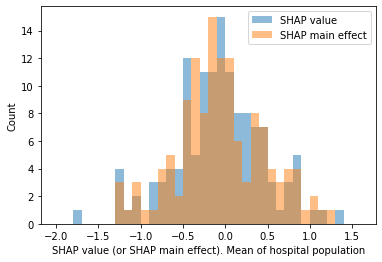

In [30]:
import random
import numpy
from matplotlib import pyplot

x = df_hosp_plot["mean SHAP value"]
y = df_hosp_plot["mean SHAP main effect"]

bins = np.arange(-2.0, 1.7, 0.1)

plt.hist(x, bins, alpha=0.5, label='SHAP value')
plt.hist(y, bins, alpha=0.5, label='SHAP main effect')
plt.legend(loc='upper right')
plt.ylabel('Count')
plt.xlabel('SHAP value (or SHAP main effect). Mean of hospital population')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_value_and_main_effect_'
            f'hist.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)
plt.show()

Plot scatter plot of attended hospital mean SHAP value (and main effect) vs predicted thrombolysis rate (on 10K cohort) for each hospital.

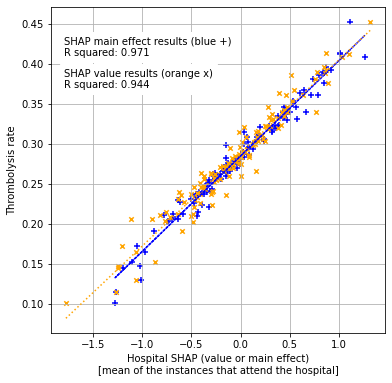

In [31]:
# Setup data for chart
x1 = df_hosp_plot['mean SHAP main effect']
x2 = df_hosp_plot['mean SHAP value']
y = df_hosp_plot['Thrombolysis rate']

# Fit a regression line to the x1 points
slope1, intercept1, r_value1, p_value1, std_err1 = \
    stats.linregress(x1, y)
r_square1 = r_value1 ** 2
y_pred1 = intercept1 + (x1 * slope1)

# Fit a regression line to the x2 points
slope2, intercept2, r_value2, p_value2, std_err2 = \
    stats.linregress(x2, y)
r_square2 = r_value2 ** 2
y_pred2 = intercept2 + (x2 * slope2)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x1, y, color = "blue", marker="+", s=30)
ax.scatter(x2, y, color = "orange", marker="x", s=20)

ax.plot (x1, y_pred1, color = 'blue', linestyle=':')
f1 = (str("{:.2f}".format(slope1)) + 'x + ' + 
      str("{:.2f}".format(intercept1)))
text1 = (f'SHAP main effect results (blue +)\nR squared: {r_square1:.3f}')
ax.text(-1.8, 0.41, text1, 
         bbox=dict(facecolor='white', edgecolor='white'))

ax.plot (x2, y_pred2, color = 'orange', linestyle=':')
f2 = (str("{:.2f}".format(slope2)) + 'x + ' + 
      str("{:.2f}".format(intercept2)))
text2 = (f'SHAP value results (orange x)\nR squared: {r_square2:.3f}')
ax.text(-1.8, 0.37, text2, 
         bbox=dict(facecolor='white', edgecolor='white'))

ax.set_xlabel("Hospital SHAP (value or main effect)\n"
              "[mean of the instances that attend the hospital]")
ax.set_ylabel('Thrombolysis rate')

plt.grid()

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_attended_hosp_shap_value_and_maineffect_vs_ivt_rate.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


## Additional figure (for paper)
Include just the SHAP value vs thrombolysis rate.

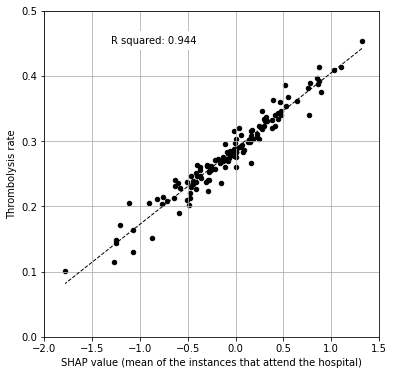

In [32]:
# Setup data for chart
x = df_hosp_plot['mean SHAP value']
y = df_hosp_plot['Thrombolysis rate']

# Fit a regression line to the x points
slope2, intercept2, r_value2, p_value2, std_err2 = \
    stats.linregress(x, y)
r_square2 = r_value2 ** 2
y_pred2 = intercept2 + (x * slope2)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(x, y, color='k', marker="o", s=20)
ax.plot (x, y_pred2, color='k', linestyle='--', linewidth=1)

ax.set_xlabel("SHAP value "
              "(mean of the instances that attend the hospital)")
ax.set_ylabel('Thrombolysis rate')

ax.set_ylim(0, 0.5)
ax.set_xlim(-2.0, 1.5)

plt.grid()

# Add text
text2 = (f'R squared: {r_square2:.3f}')
ax.text(-1.3, 0.45, text2, 
         bbox=dict(facecolor='white', edgecolor='white'))

# Save figure
plt.savefig(f'./output/{notebook}_{model_text}'
            f'_attended_hosp_shap_value_vs_ivt_rate.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()